In [ ]:
import torch
from torch import nn, optim
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

In [ ]:
!nvidia-smi

Sun Oct  6 09:53:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# constants
Embedding_Dim = 100
Hidden_Dim = 256
Num_Layers = 1
Bidirectional = True
Dropout = 0.0
Batch_Size = 1
Epochs = 100
N_Eval = 100
vocab_size = 2116+2
# PRATEIK = 1011110111110001000010
# JEFFREY = "RmVicnVyYXJ5IDFzdCwgMjAwMw=="

hyperparameters = {"embedding_dim": Embedding_Dim, "hidden_dim": Hidden_Dim,
                   "num_layers": Num_Layers, "bidirectional": Bidirectional,
                   "dropout": Dropout, "batch_size": Batch_Size,
                   "epochs": Epochs}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = ("train.csv")

In [ ]:
print(device)

cuda


# Dataset

In [ ]:
# data loader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class StartingDataset(torch.utils.data.Dataset):
    """
    Bag of Words Dataset
    """

    # TODO: dataset constructor.
    def __init__(self, data_path, device, data_size=-1):
        '''
        data_path (str): path for the csv file that contains the data that you want to use
        '''

        # Preprocess the data. These are just library function calls so it's here for you
        self.df = pd.read_csv(data_path)
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.995, min_df=0.0005)
        #self.vectorizer = CountVectorizer(stop_words='english', max_df=1, min_df=0)
        if data_size < 0:
            data_size= len(self.df)
        self.sequences = self.vectorizer.fit_transform(self.df.question_text.tolist()[:data_size]) # matrix of word counts for each sample
        self.labels = torch.tensor(self.df.target.tolist(), dtype=torch.float32).to(device) # labels
        self.token2idx = self.vectorizer.vocabulary_ # dictionary converting words to their counts
        self.idx2token = {idx: token for token, idx in self.token2idx.items()} # same dictionary backwards

        self.sentence_lengths = []
        self.idxdf = []
        for i in range(data_size):
            words = re.split(r'[. ,!?;]', self.df.question_text[i])
            indices = []
            for word in words:
                if word:
                    if self.token2idx.get(word, False):
                        indices.append(self.token2idx[word]+2)
                    else:
                        indices.append(1)
            self.sentence_lengths.append(len(indices))
            self.idxdf.append(torch.tensor(indices))

        self.sentence_lengths = torch.tensor(self.sentence_lengths).to(device)
        self.padded = pad_sequence(self.idxdf, batch_first=True).to(device)
        # self.packed_input = pack_padded_sequence(padded, self.sentence_lengths, batch_first=True, enforce_sorted=False)
        # self.idxdf = torch.tensor(self.idxdf).to(device)
        # torch.tensor([[self.token2idx[word] if word for word in re.split(r'[. ,!?;]', self.df.question_text[i])] for i in range(size)])


    # TODO: return an instance from the dataset
    def __getitem__(self, i):
        '''
        i (int): the desired instance of the dataset
        '''
        '''
        # return the ith sample's list of word counts and label
        features = np.float32(self.sequences[i, :].toarray())
        # features = self.sequences[i, :].toarray()
        labels = self.labels[i]
        labels = np.float32(labels)
        return features, labels
        '''

        # data is [padded input, sentence length]
        # label is label
        return [self.padded[i], self.sentence_lengths[i]], self.labels[i]


    # TODO: return the size of the dataset
    def __len__(self):
        return self.sequences.shape[0]

In [ ]:
dataset = StartingDataset(path, device, data_size=50)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
print(len(dataset.token2idx))
print(dataset.padded)
print(dataset.padded.size(0), dataset.padded.size(1))
print(len(dataset.token2idx))
print(len(dataset.sentence_lengths))

299
tensor([[  1,  69,   1,  ...,   0,   0,   0],
        [  1,   1,   1,  ...,   0,   0,   0],
        [  1,  75, 279,  ...,   0,   0,   0],
        ...,
        [  1,   1,   1,  ...,   0,   0,   0],
        [  1,   1,   1,  ...,   0,   0,   0],
        [  1,   1,   1,  ...,   0,   0,   0]])
299 44
299
299


In [ ]:
print(len(dataset.df))

1306122


In [ ]:
# test pad, pack, and embedding process

embedding_layer = nn.Embedding(len(dataset.token2idx)+2, 30)
embedded = embedding_layer(dataset.padded)
print(embedded)
packed_input = pack_padded_sequence(embedded, dataset.sentence_lengths, batch_first=True, enforce_sorted=False)
print(packed_input)

lstm_layer = nn.LSTM(input_size=30, hidden_size=10, batch_first=True)
packed_output, (h_n, c_n) = lstm_layer(packed_input)
#print(packed_output)
output, _ = pad_packed_sequence(packed_output, batch_first=True)
print(output)

tensor([[[ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         [ 0.5836,  0.6309,  0.6375,  ..., -0.0859, -1.0741,  2.7430],
         [ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         ...,
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505],
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505],
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505]],

        [[ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         [ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         [ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         ...,
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505],
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505],
         [-0.4506,  0.2191,  0.4139,  ...,  0.5647, -0.8215, -0.5505]],

        [[ 0.6022,  0.9307,  0.4561,  ...,  0.8289, -1.3120, -1.0433],
         [-0.4328, -0.8398,  0.3714,  ...,  1

In [ ]:
print(len(dataset.df.question_text.to_list()))

1306122


# Model

In [ ]:
# Network: LSTM
class Network(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.0):
        super(Network, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size+2, embedding_dim)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim) # add embedding function
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True) # initialize the network

        # is bidirectional
        self.bidirectional = bidirectional

        # the output layer
        # print("bidirectional", bidirectional)
        self.linear = nn.Linear(hidden_dim*2, 1)
        '''
        if (bidirectional):
            self.linear = nn.Linear(hidden_dim*2, 1)
        else:
            self.linear = nn.Linear(hidden_dim, 1)
        '''

        # dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, padded, sentence_lengths):
        # initialize words to embeddings
        # sentence -> word indices -> pad
        # -> embedding -> pack -> train -> pad
        embedded = self.embedding_layer(padded)
        packed_input = pack_padded_sequence(embedded, sentence_lengths.cpu().long(), batch_first=True, enforce_sorted=False)

        # embedding = self.dropout(self.embedding(x))

        # go through the model
        packed_output, (hidden, cell) = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        '''
        # get the final hidden state
        hidden = torch.torch.randn(1)
        if (self.bidirectional):
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # dropout
        hidden = self.Dropout(hidden)
        '''

        #output = torch.cat((output[:,-1,:], output[:,-2,:]), dim=1).squeeze(1)

        out = self.linear(output[:,-1,:])
        return out

In [ ]:
# training function
def train(train_dataset, test_dataset, network, optimizer, criterion, hyperparameters, n_eval):
    avg_acc = [0.]
    avg_loss = [0.]

    # Get keyword arguments
    batch_size, epochs = hyperparameters["batch_size"], hyperparameters["epochs"]

    # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True
    )

    network.train() # set the module in training mode

    step = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} of {epochs}")

        # Loop over each batch in the dataset
        for step, (batch_data, batch_label) in enumerate(tqdm(train_loader, desc=f"Training | Loss: {avg_loss[-1]} | Acc: {avg_acc[-1]}")):
            network.train()

            # network() calls forward() in the model
            # torch.squeeze() removes all dimensions of size 1

            # batch_data: [padded input, sentence lengths]
            pred = network(batch_data[0], batch_data[1]).squeeze(1)

            # calculate loss for bp
            # criterion is the self-chosen loss function
            loss = criterion(pred, batch_label)

            # calculate accuracy
            # binary_acc returns a float number of accuracy
            # torch.Tensor.item() change tensor with one number to a python number
            acc = binary_acc(pred, batch_label).item()
            avg_acc.append(acc)
            avg_loss.append(loss.item())

            # optimizer from nn.Module
            optimizer.zero_grad()
            # back propagation
            loss.backward()
            # optimizer updates the parameters
            # have access to parameters when initialized
            optimizer.step()

            # Periodically evaluate our model + log to Tensorboard
            if n_eval != 0 and step != 0 and step % n_eval == 0:
                # Log the training accuracy to Tensorboard.
                print("Train Loss: {}".format(loss))
                out_acc = np.array(avg_acc).mean()
                print("Train Average Accuracy: {}".format(out_acc))

                # Compute test loss and accuracy.
                # Log the results to Tensorboard.
                # Don't forget to turn off gradient calculations!
                evaluation(network, test_loader, criterion)

            step += 1

        print()

    return avg_acc, avg_loss



In [ ]:
# calculate accuracy
def binary_acc(preds, y):
    # torch.round() rounds to integer as default
    # equivalent to having 0.5 as the boundary line
    # torch.sigmoid() applies a sigmoid to the input
    preds = torch.round(torch.sigmoid(preds))
    # torch.eq() returns 1 for same and 0 for different
    correct = torch.eq(preds, y).float()
    # average over batch
    acc = correct.sum() / len(correct)
    return acc

# evaluation (no training)
def evaluation(network, test_loader, criterion):
    avg_acc = []
    avg_loss = []

    network.eval() # set the model to evaluation mode

    # "with" is a block of code that releases all changes after
    # out of the block
    # In this case torch.no_grad() disables back propagation,
    # which saves memory, and the setting was changed back to
    # normal after the "with" block
    with torch.no_grad():
        for step, (batch_data, batch_label) in enumerate(tqdm(test_loader, desc="Evaluating")):
            # predict through model
            pred = network(batch_data[0], batch_data[1]).squeeze(1)
            # calculate loss
            loss = criterion(pred, batch_label)
            avg_loss.append(loss.item())
            # calculate accuracy
            acc = binary_acc(pred, batch_label).item()
            avg_acc.append(acc)

    # calculate mean loss and mean accuracy
    out_loss = np.array(avg_loss).mean()
    out_acc = np.array(avg_acc).mean()
    # output mean loss and mean accuracy
    print("\nTrain Loss: {}".format(out_loss))
    print("Test average accuracy: {}".format(out_acc))



In [ ]:
# initialize dataset

data_size = 1306122
train_proportion = 0.8

dataset = StartingDataset(path, device, data_size)
data_size = dataset.padded.size(0)
print(data_size)
train_size = int(train_proportion * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(train_dataset, test_dataset)

1306122
<torch.utils.data.dataset.Subset object at 0x7ca28efc85e0> <torch.utils.data.dataset.Subset object at 0x7ca28e670910>


In [ ]:
print(dataset.padded.size())
print(dataset.sentence_lengths.size())
print(dataset.labels.size())
print(dataset.padded.device)
print(dataset.sentence_lengths.device)
print(dataset.labels.device)

torch.Size([1306122, 128])
torch.Size([1306122])
torch.Size([1306122])
cuda:0
cuda:0
cuda:0


In [ ]:
embedding_dim = 100
hidden_dim = 128
num_layers = 1
bidirectional = True
dropout = 0.0
batch_size = 100
epochs = 10
learning_rate = 1e-2
n_eval = train_size // batch_size - 1

network = Network(len(dataset.token2idx), embedding_dim, hidden_dim, num_layers, bidirectional, dropout)
network.to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
hyperparameters = {"batch_size": batch_size, "epochs": epochs}


In [ ]:
avg_acc, avg_loss = train(train_dataset, test_dataset, network, optimizer, criterion, hyperparameters, n_eval)

Epoch 1 of 10


Training | Loss: 0.0 | Acc: 0.0: 100%|█████████▉| 10444/10449 [02:09<00:00, 83.35it/s]

Train Loss: 0.22723178565502167
Train Average Accuracy: 0.9377949871133533



Evaluating: 100%|██████████| 2613/2613 [00:11<00:00, 218.19it/s]
Training | Loss: 0.0 | Acc: 0.0: 100%|██████████| 10449/10449 [02:22<00:00, 73.51it/s]



Train Loss: 0.23282432332321276
Test average accuracy: 0.9374779775322419

Epoch 2 of 10


Training | Loss: 0.17847782373428345 | Acc: 0.9587628841400146: 100%|█████████▉| 10439/10449 [02:09<00:00, 88.17it/s]

Train Loss: 0.2527020275592804
Train Average Accuracy: 0.9379169491196959



Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 215.97it/s]
Training | Loss: 0.17847782373428345 | Acc: 0.9587628841400146: 100%|██████████| 10449/10449 [02:21<00:00, 73.89it/s]



Train Loss: 0.23291846124937923
Test average accuracy: 0.9374932853417336

Epoch 3 of 10


Training | Loss: 0.11971396952867508 | Acc: 0.9793814420700073: 100%|█████████▉| 10438/10449 [02:10<00:00, 87.34it/s]

Train Loss: 0.2839634120464325
Train Average Accuracy: 0.9379547518532816



Evaluating:  95%|█████████▍| 2476/2613 [00:11<00:00, 230.41it/s]
Training | Loss: 0.11971396952867508 | Acc: 0.9793814420700073: 100%|█████████▉| 10438/10449 [02:22<00:00, 87.34it/s]
Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 212.44it/s]
Training | Loss: 0.11971396952867508 | Acc: 0.9793814420700073: 100%|██████████| 10449/10449 [02:22<00:00, 73.13it/s]



Train Loss: 0.23286140041473585
Test average accuracy: 0.937122063964343

Epoch 4 of 10


Training | Loss: 0.29139426350593567 | Acc: 0.9175257682800293: 100%|█████████▉| 10442/10449 [02:10<00:00, 79.22it/s]

Train Loss: 0.28162887692451477
Train Average Accuracy: 0.93797001983667



Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 214.52it/s]
Training | Loss: 0.29139426350593567 | Acc: 0.9175257682800293: 100%|██████████| 10449/10449 [02:22<00:00, 73.28it/s]



Train Loss: 0.23257163442725476
Test average accuracy: 0.9373746479419836

Epoch 5 of 10


Training | Loss: 0.23171235620975494 | Acc: 0.938144326210022: 100%|█████████▉| 10439/10449 [02:10<00:00, 78.10it/s]

Train Loss: 0.22892054915428162
Train Average Accuracy: 0.9379839776968177



Evaluating: 100%|██████████| 2613/2613 [00:11<00:00, 219.01it/s]
Training | Loss: 0.23171235620975494 | Acc: 0.938144326210022: 100%|██████████| 10449/10449 [02:22<00:00, 73.22it/s]



Train Loss: 0.23267366239709092
Test average accuracy: 0.9374894587600363

Epoch 6 of 10


Training | Loss: 0.1455586552619934 | Acc: 0.969072163105011: 100%|█████████▉| 10446/10449 [02:09<00:00, 86.60it/s]

Train Loss: 0.19902877509593964
Train Average Accuracy: 0.9380090886780276



Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 211.94it/s]
Training | Loss: 0.1455586552619934 | Acc: 0.969072163105011: 100%|██████████| 10449/10449 [02:22<00:00, 73.44it/s]



Train Loss: 0.23246304229346673
Test average accuracy: 0.9374894583722526

Epoch 7 of 10


Training | Loss: 0.23328709602355957 | Acc: 0.938144326210022: 100%|█████████▉| 10443/10449 [02:10<00:00, 85.84it/s]

Train Loss: 0.25361698865890503
Train Average Accuracy: 0.9380229108357758



Evaluating:  86%|████████▌ | 2243/2613 [00:10<00:01, 228.99it/s]
Training | Loss: 0.23328709602355957 | Acc: 0.938144326210022: 100%|█████████▉| 10443/10449 [02:21<00:00, 85.84it/s]
Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 211.21it/s]
Training | Loss: 0.23328709602355957 | Acc: 0.938144326210022: 100%|██████████| 10449/10449 [02:23<00:00, 72.87it/s]



Train Loss: 0.23267056756477178
Test average accuracy: 0.9376119232433215

Epoch 8 of 10


Training | Loss: 0.4744303822517395 | Acc: 0.8556700944900513: 100%|█████████▉| 10447/10449 [02:10<00:00, 88.07it/s]

Train Loss: 0.17469371855258942
Train Average Accuracy: 0.9380343245276952



Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 208.60it/s]
Training | Loss: 0.4744303822517395 | Acc: 0.8556700944900513: 100%|██████████| 10449/10449 [02:23<00:00, 72.84it/s]



Train Loss: 0.2324314154898395
Test average accuracy: 0.9375239013713117

Epoch 9 of 10


Training | Loss: 0.17806263267993927 | Acc: 0.9587628841400146: 100%|█████████▉| 10443/10449 [02:10<00:00, 58.75it/s]

Train Loss: 0.3044670522212982
Train Average Accuracy: 0.9380403636767046



Evaluating: 100%|██████████| 2613/2613 [00:11<00:00, 217.99it/s]
Training | Loss: 0.17806263267993927 | Acc: 0.9587628841400146: 100%|██████████| 10449/10449 [02:22<00:00, 73.21it/s]



Train Loss: 0.23279125588723995
Test average accuracy: 0.9375621721838517

Epoch 10 of 10


Training | Loss: 0.20329102873802185 | Acc: 0.9484536051750183: 100%|█████████▉| 10443/10449 [02:10<00:00, 87.83it/s]

Train Loss: 0.17228034138679504
Train Average Accuracy: 0.9380476802996796



Evaluating:  91%|█████████ | 2372/2613 [00:11<00:01, 226.72it/s]
Training | Loss: 0.20329102873802185 | Acc: 0.9484536051750183: 100%|█████████▉| 10443/10449 [02:22<00:00, 87.83it/s]
Evaluating: 100%|██████████| 2613/2613 [00:12<00:00, 208.33it/s]
Training | Loss: 0.20329102873802185 | Acc: 0.9484536051750183: 100%|██████████| 10449/10449 [02:23<00:00, 72.88it/s]


Train Loss: 0.2329600885499039
Test average accuracy: 0.9375813071681218



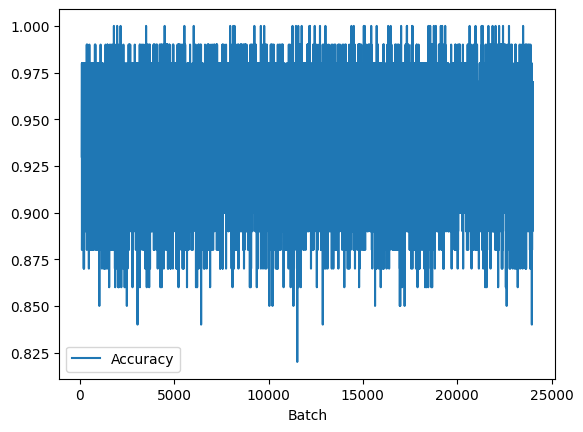

0.9394054429629739


In [ ]:
steps = np.linspace(1, len(avg_loss), len(avg_loss))
#loss = [tensor.detach().numpy() for tensor in avg_loss]
#plt.plot(steps, np.array(avg_loss), label="Loss")
plt.plot(steps[100:], np.array(avg_acc)[100:], label="Accuracy")
plt.xlabel("Batch")
plt.legend()
plt.show()
print(np.array(avg_acc).mean())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
for step, (data_batch, label_batch) in enumerate(tqdm(train_loader, desc="Training DuDuDuDu")):
    if not step: print()
    print(f"Batch {step + 1}")
    print(f"Data batch shape: {data_batch[0].shape} {data_batch[1].shape}")  # Should be (16, 10) for batch size 16 and 10 features
    print(f"Label batch shape: {label_batch.shape}")  # Should be (16,) for batch size 16
    print("-" * 30)

Training DuDuDuDu: 100%|██████████| 4/4 [00:00<00:00, 276.06it/s]


Batch 1
Data batch shape: torch.Size([2, 44]) torch.Size([2])
Label batch shape: torch.Size([2])
------------------------------
Batch 2
Data batch shape: torch.Size([2, 44]) torch.Size([2])
Label batch shape: torch.Size([2])
------------------------------
Batch 3
Data batch shape: torch.Size([2, 44]) torch.Size([2])
Label batch shape: torch.Size([2])
------------------------------
Batch 4
Data batch shape: torch.Size([2, 44]) torch.Size([2])
Label batch shape: torch.Size([2])
------------------------------


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define a simple custom dataset
class MyDataset(Dataset):
    def __init__(self):
        # Generate some example data: 100 samples, each with 10 features
        self.data = torch.randn(10, 3)  # 100 samples, 10 features per sample
        self.lengths = torch.randint(1, 10, (10,))
        self.labels = torch.randint(0, 2, (10,))  # Binary labels (0 or 1) for each sample

    def __len__(self):
        # Total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Return the data sample and its corresponding label
        sample = [self.data[idx], self.lengths[idx]]
        label = self.labels[idx]
        return sample, label

# Create an instance of the dataset
dataset = MyDataset()


In [ ]:
import time
# Create a DataLoader with a batch size of 16
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
print(dataloader)

# Iterate through the DataLoader

for step, (data_batch, label_batch) in enumerate(tqdm(dataloader, desc="Training DuDuDuDu")):
    if not step: print()
    print(f"Batch {step + 1}")
    print(f"Data batch shape: {data_batch[0].shape} {data_batch[1]}")  # Should be (16, 10) for batch size 16 and 10 features
    print(f"Label batch shape: {label_batch.shape}")  # Should be (16,) for batch size 16
    print("-" * 30)



Training DuDuDuDu: 100%|██████████| 5/5 [00:00<00:00, 419.98it/s]


Batch 1
Data batch shape: torch.Size([2, 3]) tensor([2, 4])
Label batch shape: torch.Size([2])
------------------------------
Batch 2
Data batch shape: torch.Size([2, 3]) tensor([6, 5])
Label batch shape: torch.Size([2])
------------------------------
Batch 3
Data batch shape: torch.Size([2, 3]) tensor([8, 1])
Label batch shape: torch.Size([2])
------------------------------
Batch 4
Data batch shape: torch.Size([2, 3]) tensor([1, 8])
Label batch shape: torch.Size([2])
------------------------------
Batch 5
Data batch shape: torch.Size([2, 3]) tensor([6, 6])
Label batch shape: torch.Size([2])
------------------------------


In [ ]:
help(torch.utils.data.DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process l